In [1]:
import pandas as pd
from datetime import timedelta

dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8'}

train = pd.read_csv('train.csv', usecols=[1,2,3,4], dtype=dtypes, parse_dates=['date'],
                    skiprows=range(1, 101688779) #Skip dates before 2017-01-01
                    )

train.loc[(train.unit_sales<0),'unit_sales'] = 0 # eliminate negatives
#train['unit_sales'] =  train['unit_sales'].apply(pd.np.log1p) #logarithm conversion

# creating records for all items, in all markets on all dates
# for correct calculation of daily unit sales averages.
u_dates = train.date.unique()
u_stores = train.store_nbr.unique()
u_items = train.item_nbr.unique()
train.set_index(["date", "store_nbr", "item_nbr"], inplace=True)
train = train.reindex(
    pd.MultiIndex.from_product(
        (u_dates, u_stores, u_items),
        names=["date", "store_nbr", "item_nbr"]
    )
)

del u_dates, u_stores, u_items

train.loc[:, "unit_sales"].fillna(0, inplace=True)
train.reset_index(inplace=True) # reset index and restoring unique columns  
lastdate = train.iloc[train.shape[0]-1].date

In [2]:
import numpy as np
look_back = 7

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [3]:
print(train[(train["unit_sales"]>0)].reset_index(drop=True))

               date  store_nbr  item_nbr  unit_sales
0        2016-12-31         54   2048674         1.0
1        2017-01-01         25     99197         1.0
2        2017-01-01         25    103665         7.0
3        2017-01-01         25    105574         1.0
4        2017-01-01         25    105857         4.0
5        2017-01-01         25    106716         2.0
6        2017-01-01         25    108698         2.0
7        2017-01-01         25    108786         1.0
8        2017-01-01         25    108797         1.0
9        2017-01-01         25    108862         1.0
10       2017-01-01         25    108952         2.0
11       2017-01-01         25    114790         2.0
12       2017-01-01         25    114800         6.0
13       2017-01-01         25    115267         2.0
14       2017-01-01         25    115693         1.0
15       2017-01-01         25    115720         6.0
16       2017-01-01         25    115850         1.0
17       2017-01-01         25    115891      

In [4]:
# 123347 - calm, medium amp
# 119624 - weird spike?
# 2113343 - new prod
# 123347 - 
# 105857

t_123347 = train[(train["item_nbr"]==123347) & (train["store_nbr"]==1)]["unit_sales"].reset_index(drop=True)
t_105857 = train[(train["item_nbr"]==105857) & (train["store_nbr"]==1)]["unit_sales"].reset_index(drop=True)

from sklearn.preprocessing import MinMaxScaler
#scaler1 = MinMaxScaler(feature_range=(0, 1))
#scaler2 = MinMaxScaler(feature_range=(0, 1))
#t_123347 = scaler1.fit_transform(t_123347.values.reshape(-1,1))
#t_105857 = scaler2.fit_transform(t_105857.values.reshape(-1,1))

t_123347_in, t_123347_ot = create_dataset(t_123347, look_back)
t_105857_in, t_105857_ot = create_dataset(t_105857, look_back)

in_comb = np.append(t_123347_in, t_105857_in, axis = 0)
ot_comb = np.append(t_123347_ot, t_105857_ot, axis = 0)

ValueError: Can only tuple-index with a MultiIndex

In [54]:
train_size = int(len(t_123347)*2 * 0.67)
test_size = len(t_123347)*2 - train_size
print(train_size)
print(test_size)


305
151


In [55]:
train_input, train_output = in_comb[:train_size,:], ot_comb[:train_size,:]
test_input, test_output = in_comb[train_size:,:], ot_comb[train_size:,:]
print(train_input.shape)

(305, 7, 1)


In [56]:
trainX = np.reshape(train_input, (train_input.shape[0], train_input.shape[1], train_input.shape[2]))
trainY = train_output
print(trainX.shape)
print(test_input.shape)
testX = np.reshape(test_input, (test_input.shape[0], test_input.shape[1], test_input.shape[2]))
testY = test_output

(305, 7, 1)
(135, 7, 1)


In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


In [61]:
model = Sequential()
model.add(LSTM(400,input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=40, verbose=2)

Epoch 1/100
0s - loss: 0.0506
Epoch 2/100
0s - loss: 0.0349
Epoch 3/100
0s - loss: 0.0350
Epoch 4/100
0s - loss: 0.0343
Epoch 5/100
0s - loss: 0.0340
Epoch 6/100
0s - loss: 0.0339
Epoch 7/100
0s - loss: 0.0338
Epoch 8/100
0s - loss: 0.0338
Epoch 9/100
0s - loss: 0.0338
Epoch 10/100
0s - loss: 0.0337
Epoch 11/100
0s - loss: 0.0336
Epoch 12/100
0s - loss: 0.0334
Epoch 13/100
0s - loss: 0.0337
Epoch 14/100
0s - loss: 0.0335
Epoch 15/100
0s - loss: 0.0335
Epoch 16/100
0s - loss: 0.0339
Epoch 17/100
0s - loss: 0.0336
Epoch 18/100
0s - loss: 0.0331
Epoch 19/100
0s - loss: 0.0336
Epoch 20/100
0s - loss: 0.0341
Epoch 21/100
0s - loss: 0.0338
Epoch 22/100
0s - loss: 0.0332
Epoch 23/100
0s - loss: 0.0335
Epoch 24/100
0s - loss: 0.0336
Epoch 25/100
0s - loss: 0.0332
Epoch 26/100
0s - loss: 0.0333
Epoch 27/100
0s - loss: 0.0339
Epoch 28/100
0s - loss: 0.0343
Epoch 29/100
0s - loss: 0.0347
Epoch 30/100
0s - loss: 0.0335
Epoch 31/100
0s - loss: 0.0333
Epoch 32/100
0s - loss: 0.0331
Epoch 33/100
0s -

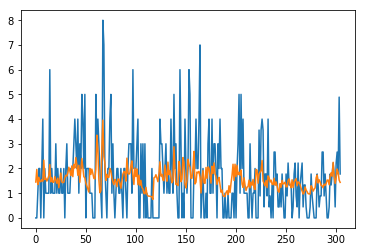

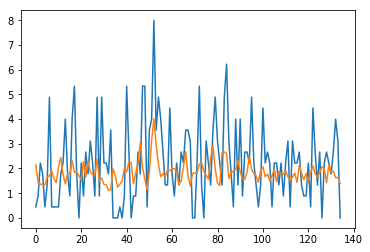

In [62]:
import matplotlib.pyplot as plt
import math

trainPredict = scaler1.inverse_transform(model.predict(trainX))
testPredict = scaler1.inverse_transform(model.predict(testX))
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))

#trainPredictPlot = np.empty_like(lstm_input)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
truth_train = scaler1.inverse_transform(train_input[:,0].reshape(-1, 1))
truth_test = scaler1.inverse_transform(test_input[:,0].reshape(-1, 1))

plt.plot(truth_train)
plt.plot(trainPredict)
plt.show()
plt.plot(truth_test)
plt.plot(testPredict)
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(truth_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

mean = truth_train.copy()
mean.fill(truth_train.mean())
trainMean = math.sqrt(mean_squared_error(truth_train, mean[:,0]))
print('Mean: %.2f RMSE' % (trainMean))

testScore = math.sqrt(mean_squared_error(truth_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

mean2 = truth_test.copy()
mean2.fill(truth_test.mean())
testMean = math.sqrt(mean_squared_error(truth_test, mean2[:,0]))
print('Mean: %.2f RMSE' % (testMean))


Train Score: 1.38 RMSE
Mean: 1.50 RMSE
Test Score: 1.53 RMSE
Mean: 1.57 RMSE
